In [67]:
import pandas as pd
import seaborn as sns
import pingouin as pg
import scipy.stats as st
import numpy as np

In [68]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [69]:
data = pd.read_csv('dating_data.csv')

In [70]:
data.info() # смотрим, все ли данные на месте

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [71]:
data

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


__Сначала смотрю логику сбора данных.__  
Хотел понять, дублируются ли пары для каждого юзера или пара отображается единожды.  

Елси бы отображались для каждого юзера, тогда pair и mirror_pair были бы идентичны, но они разные. Так что понимаем, что пара отображается единожды.
По суту, можно было бы это понять гораздо легче - посмотрев на сортированный список, но решил сделать так для наглядности.

In [72]:
pair = pd.DataFrame(data.user_id_1.apply(lambda x: str(x)) + data.user_id_2.apply(lambda x: str(x))).sort_values(0).reset_index(drop = True)
mirror_pair = pd.DataFrame(data.user_id_2.apply(lambda x: str(x)) + data.user_id_1.apply(lambda x: str(x))).sort_values(0).reset_index(drop = True)

In [73]:
pair.merge(mirror_pair, left_index=True, right_index=True)

,0_x,0_y
0,1000124,1000168
1,1000163,1000267
2,1000289,1000294
3,100029,1000321
4,1000320,1000416
...,...,...
14509,999712,999762
14510,99977,999817
14511,99978,999920
14512,999939,999945


После визуально оцениваю, что по соотношению матч/не матч для обоих групп

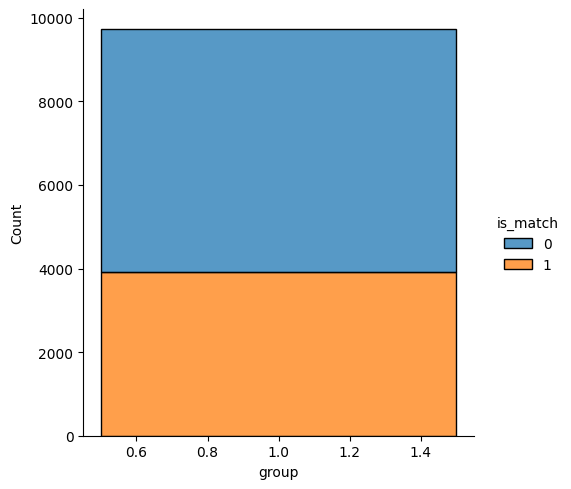

In [74]:
sns.displot(data.query("group == 1"), x = 'group', hue = 'is_match', multiple="stack")

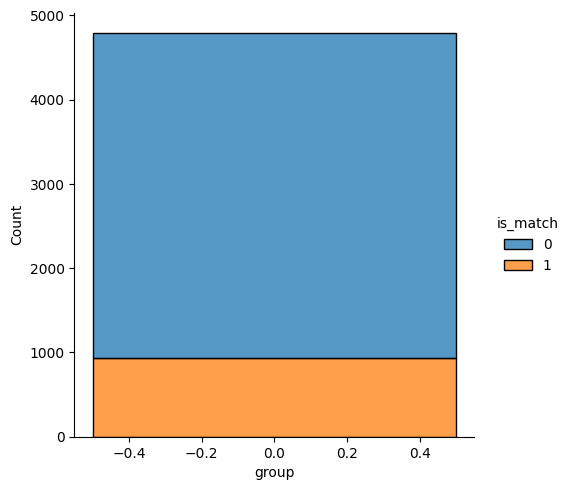

In [75]:
sns.displot(data.query("group == 0"), x = 'group', hue = 'is_match', multiple="stack")

Вижу, что отличия есть в положительную сторону для нового алгоритма

## Провожу оценку с помощью хи-квадрат:
    H0 - распределение матчей не зависит от вида системы рекомендации

In [76]:
for_chi = pd.DataFrame()
for_chi['group_0'] = [data.query("group == 0").is_match.sum(), data.query("group == 0 & is_match == 0").is_match.count()]
for_chi['group_1'] = [data.query("group == 1").is_match.sum(), data.query("group == 1 & is_match == 0").is_match.count()]

In [77]:
for_chi

,group_0,group_1
0,934,3909
1,3858,5813


In [78]:
chi, p, x, y = st.chi2_contingency(for_chi)
p

1.4418299163662586e-136

__Вывод__: p < 0.05 - отклоняем нулевую гипотезу

## Далее дополнительно смотрю конверсию матчи/предложенные пары

In [79]:
for_bar = pd.DataFrame()
a = data.query("group == 0").is_match.sum() / data.query("group == 0").is_match.count() * 100
b = data.query("group == 1").is_match.sum() / data.query("group == 1").is_match.count() * 100
for_bar['group'] = ['a', 'b']
for_bar['conversion'] = [a, b]

In [80]:
for_bar

,group,conversion
0,a,19.490818
1,b,40.207776


<Axes: xlabel='group', ylabel='conversion'>

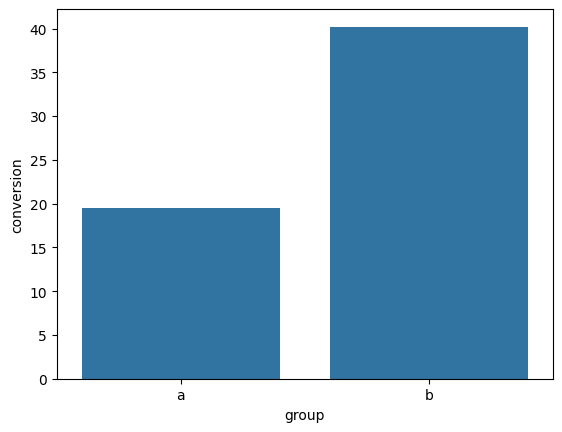

In [81]:
sns.barplot(data = for_bar, y = 'conversion', x = 'group')

H0: распределение конверсии не зависит от вида системы рекомендации

In [82]:
for_chi_conv = pd.DataFrame()
for_chi_conv['A'] = [a, 100 - a]
for_chi_conv['B'] = [b, 100 - b]

In [83]:
for_chi_conv

,A,B
0,19.490818,40.207776
1,80.509182,59.792224


In [84]:
chi, p, x, y = st.chi2_contingency(for_chi_conv)
p

0.0023130287226545213

__Вывод__: p < 0.05 - отклоняем нулевую гипотезу

## И третий вариант - хочу посмотреть локальную конверсию.
Начальный датафрейм продублирую по строкам, так, чтобы далее скомпоновать конверсию для каждого отдельного пользователя, а после посмотреть распределение по данным конверсиям

In [85]:
pair_data = pd.concat([data, data], ignore_index=True)
pair_data = pair_data[['user_id_1', 'group', 'is_match']]

In [86]:
pair_data

,user_id_1,group,is_match
0,79,1,1
1,716,1,1
2,423,0,0
3,658,1,1
4,969,0,1
...,...,...,...
29023,476,0,0
29024,455,1,0
29025,260,1,1
29026,885,1,1


In [87]:
count = pair_data.groupby(['user_id_1', 'group'], as_index = False).agg({'is_match' : 'count'})

In [88]:
conversion_data = pd.DataFrame()
conversion_data['user_id'] = count.user_id_1
conversion_data['group'] = count.group
conversion_data['action'] = count.is_match
conversion_data['match'] = pair_data.groupby(['user_id_1', 'group'], as_index = False).agg({'is_match' : 'sum'}).is_match
conversion_data['conversion'] = round(conversion_data.match / conversion_data.action * 100, 2)

In [89]:
conversion_data.query('conversion == 0')

,user_id,group,action,match,conversion
13,14,0,16,0,0.0
18,19,0,14,0,0.0
19,20,0,14,0,0.0
29,30,0,4,0,0.0
35,36,0,10,0,0.0
...,...,...,...,...,...
920,921,0,6,0,0.0
943,944,0,26,0,0.0
949,950,0,22,0,0.0
964,965,0,10,0,0.0


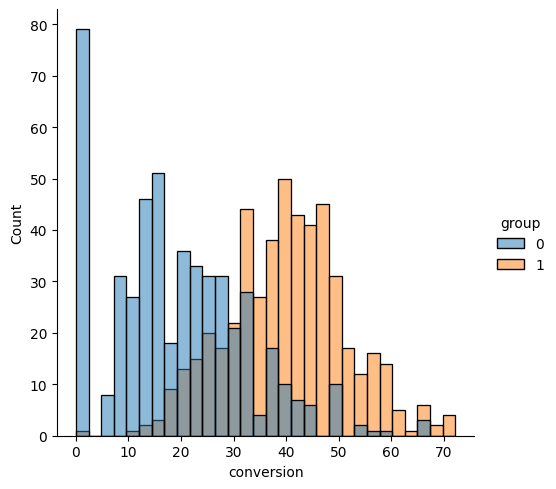

In [90]:
sns.displot(data = conversion_data, x = 'conversion', hue = 'group',  bins = 30)

Интересное наблюдение - у группы 0 гораздо больше пользователей с показателем конверсии 0

Видим, что распределение в выборке 0 явно не соответсвтует нормальному распределению. Пробую преобразовать.

In [91]:
conversion_data['log_conv'] = conversion_data.conversion.apply(lambda x: np.log(x + 1))


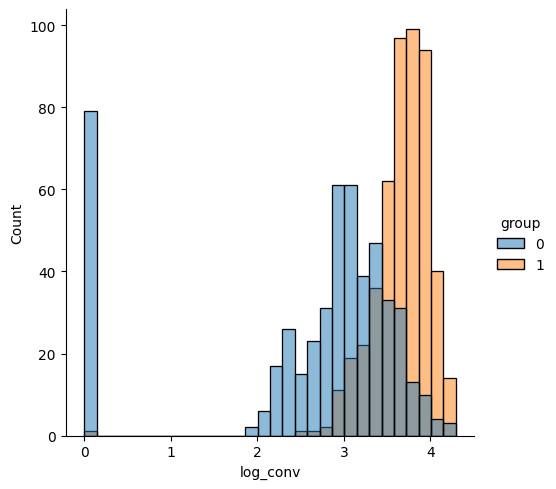

In [92]:
sns.displot(data = conversion_data, x = 'log_conv', hue = 'group',  bins = 30)

Преобразование данных не особо помогло.
Попробую использовать непараметрику.

H0: распределения выборок A и B равны

In [93]:
st.kstest(conversion_data.query('group == 0').conversion, conversion_data.query('group == 1').conversion)

KstestResult(statistic=0.6279745118980475, pvalue=7.224239751089469e-93, statistic_location=30.77, statistic_sign=1)

__Вывод__: p < 0.05
Распредения отличаются

__Вывод__: по полученным данным новый алгоритм предоставляет лучший подбор пар.
Для постановки вывода я буду принимать во внимание именно первый вариант своего решения, а второй и трейти варианты больше для поиграть с данными, и узнать, можно ли вообще так делать.

Ещё я бы предпочел для АB теста использовать не данные о паре/матч, а по показу пары/лайк. Так гораздо больше пространства для исследований